# Decision Analysis Project 1

- Mateusz Tabaszewski 151945
- Bartłomiej Pukacki 151942

This is our notebook dedicated to the first project from decision analysis classes, in this notebook we set out to implement our own versions of PROMETHEE I and II as well as SRF and ELECTRE TRI-B methods used for multi-criteria decision analysis (MCDA). In this notebook we have created a dataset based on real data of video games for the sake of solving the task of ranking (PROMETHEE I and II) and sorting to allow the user to choose what game they should dedicate their time to.

Sections present in this notebook:
* Imports - imports used for the notebook
* Utilities - general functions and classes which can be used outside the implemented methods
* Data - Description and showcase of the constructed dataset, asnwers to the 3.1 section from report requirements
* SRF - Implementation and use of SRF method
* PROMETHEE - Implementation and use of the PROMETHEE method, answers to the 3.2 section from report requirements
* ELECTRE - Implementation and use of ELECTREE TRI-B method, answers to the 3.3 section from report requirements
* Conclusions and Comparison of Methods' Results - short conclusions and comparison of models' results - answers to the section 3.4

## Imports

Section dedicated to imports used in the Project 1 for Decision Analysis classes.

In [ ]:
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from typing import List, Union

## Utilities

Section dedicated to general utility purposes, functions and classes declared here can be used all across the notebook due to their universality, or just because it might be beneficial to seperate them from remaining classes/functions definitions

In [ ]:
def calculate_value(value, q, p):
    '''
    Calculates preference function value for given value.
    '''
    if value > p:
        return 1.0
    elif value<=q:
        return 0
    return (value-q)/(p-q)

def calculate_concordance_index(a, b, q, p, type):
    '''
    Calculates concordance index value for given value and criteria type.
    '''
    if type == "gain":
        if a-b >= -q:
            return 1.0
        elif a-b < -p:
            return 0

        return (p - (b-a))/(p-q)

    elif type == "cost":
        if a-b <= q:
            return 1.0
        elif a-b > p:
            return 0

        return (p - (a-b))/(p-q)

    raise Exception("Wrong type provided")

def calculate_discordance_index(a, b, v, p, type):
    '''
    Calculates concordance index value for given value and criteria type.
    '''
    if type == "gain":
        if a-b <= -v:
            return 1.0
        elif a-b >= -p:
            return 0

        return ((b-a) - p)/(v-p)

    elif type == "cost":
        if a-b >= v:
            return 1.0
        elif a-b <= p:
            return 0

        return ((a-b) - p)/(v-p)

    raise Exception("Wrong type provided")

class Criteria:
    '''
    Criteria class for PROMETHEE implementations.
    '''
    def __init__(self, name: str, criteria_type: str, w: float, q: float, p: float):
        '''
        Initialize instance of Criteria.
        Parameters:
            - name (str): Criteria name, e.g. (cost, completion time, rating, etc.)
            - criteria_type (str): Criteria type - 'gain' (higher values preffered) or 'cost' (lower values preffered)
            - w (float): Criteria weight
            - q (float): Indifference threshold
            - p (float): Perference threshold
         '''
        self.name = name
        assert criteria_type.lower() == "gain" or criteria_type.lower() == "cost", "Invalid criteria type"
        assert q<=p and p>=0 and q>=0 and w>=0, "Invalid values, expected: q<p<v and q,p,w >=0"
        assert not np.isposinf(w) and not np.isneginf(w), "Invalid value, weight cannot be infinite"
        self.criteria_type = criteria_type.lower()
        self.w = w
        self.q = q
        self.p = p

    def __str__(self):
        '''
        Print information about Criteria.
        '''
        criteria_info = f"Criteria: {self.name} \n type: {self.criteria_type} \n w: {self.w} \n q: {self.q} \n p: {self.p}"

        return criteria_info

class Criteria_ELECTRE:
    '''
    Criteria class for ELECTRE implementations.
    '''
    def __init__(self, name: str, criteria_type: str, w: float, q: List[float], p: List[float], v: List[float], boundary_profiles: List = None):
        '''
        Initialize instance of Criteria.
        Parameters:
            - name (str): Criteria name, e.g. (cost, completion time, rating, etc.)
            - criteria_type (str): Criteria type - 'gain' (higher values preffered) or 'cost' (lower values preffered)
            - w float: Criteria weight
            - q (List[float]): Indifference threshold, must be defined in a list for each boundary profile
            - p (List[float]): Perference threshold, must be defined in a list for each boundary profile
            - v (List[float]): Veto threshold, use float("inf") for no veto threshold, must be defined in a list for each boundary profile
            - boundary_profiles (list, optional): Boundary profiles sorted from worst to best according to their type
        '''
        self.name = name
        assert criteria_type.lower() == "gain" or criteria_type.lower() == "cost", "Invalid criteria type"
        assert not np.isposinf(w) and not np.isneginf(w), "Invalid value, weight cannot be infinite"
        self.criteria_type = criteria_type.lower()
        self.w = w
        self.q = q
        self.p = p
        self.v = v
        self.boundary_profiles = boundary_profiles

    def __str__(self):
        '''
        Print information about Criteria.
        '''
        criteria_info = f"Criteria: {self.name} \n type: {self.criteria_type} \n w: {self.w}\n"

        if self.boundary_profiles is not None:
            for i, b in enumerate(self.boundary_profiles):
                criteria_info += f" b_{i}: {b}, p_{i}: {self.p[i]}, q_{i}: {self.q[i]}, v_{i}: {self.v[i]}\n"

        return criteria_info

## Data

### Game Dataset
Dataset chosen and constructed by us based on publically available data is related with the topic of video games. We have decided to choose a number of interesting and varied games and obtained various criteria relating to these games from different websites. We would like to apply the methods commonly used in decision analysis to allow the user an easier time deciding about what the ranking and sorting of these games might be. Thanks to intuitive and interpretible criteria and well-known set of alternatives we can easily assess the quality of the system based on the presented results.

### Data set

**ID**: name<br>
**gain**: critic_score, user_score, length, genres, num_of_achievements<br>
**cost**: price<br>

| name                          | price | critic_score | user_score | length | genres                           | num_of_achievements |
|-------------------------------|-------|--------------|------------|--------|----------------------------------|---------------------|
| Dark Souls: Remastered        | 150   | 84           | 83         | 44     | Action, Adventure, RPG           | 41                  |
| Dark Souls III                | 200   | 89           | 90         | 49     | Action, Adventure, RPG           | 43                  |
| Terraria                      | 46    | 81           | 81         | 102    | Survival, Adventure, RPG         | 115                 |
| Baldur's Gate 3               | 250   | 96           | 89         | 107    | Strategy, Adventure, RPG         | 54                  |
| Dave the Diver                | 92    | 90           | 83         | 32     | Adventure, RPG                   | 43                  |
| Rust                          | 153   | 69           | 65         | 37     | Action, Adventure, Survival, FPS | 92                  |
| Hollow Knight                 | 68    | 90           | 91         | 42     | Action, Adventure, Platformer    | 63                  |
| Portal 2                      | 46    | 95           | 89         | 14     | Action, Puzzle, FPS              | 51                  |
| Vampire Survivors             | 20    | 86           | 83         | 25     | Action, RPG, Arcade              | 204                 |
| Hades                         | 115   | 93           | 88         | 49     | Action, RPG, Hack-and-slash      | 49                  |
| Subnautica                    | 139   | 87           | 86         | 43     | Survival, Adventure              | 17                  |
| Dishonored                    | 45    | 88           | 83         | 18     | Action, RPG, FPS                 | 80                  |
| Ori and the Will of the Wisps | 108   | 90           | 89         | 16     | Action, Adventure, Platformer    | 37                  |
| Inside                        | 72    | 93           | 83         | 4      | Adventure, Puzzle                | 14                  |
| The Forest                    | 72    | 83           | 75         | 28     | Action, Survival, Adventure      | 45                  |
| Skyrim                        | 90    | 96           | 86         | 114    | Action, Adventure, RPG           | 75                  |
| Teardown                      | 120   | 80           | 81         | 22     | Action, Puzzle                   | 27                  |
| Dying Light                   | 90    | 74           | 81         | 36     | Action, Survival                 | 78                  |
| Enter the Gungeon             | 68    | 82           | 80         | 62     | Action                           | 54                  |
| Payday 3                      | 169   | 66           | 31         | 10     | Action, FPS                      | 22                  |
| Kao the Kangaroo              | 129   | 65           | 75         | 8      | Action, Adventure                | 26                  |
| Assassin's Creed Unity        | 120   | 72           | 56         | 35     | Action, Adventure, RPG           | 57                  |
| Trials Fusion                 | 80    | 79           | 71         | 23     | Platformer                       | 51                  |
| The Sims 3                    | 28    | 83           | 78         | 78     | RPG                              | 65                  |
| Titan Souls                   | 68    | 74           | 61         | 4      | Action, Adventure                | 27                  |

### Converted genres with preference:

| genre          | points |
|----------------|--------|
| Action         | 4      |
| Adventure      | 4      |
| RPG            | 3      |
| Platformer     | 2      |
| Puzzle         | 2      |
| Hack-and-slash | 2      |
| Arcade         | 2      |
| FPS            | 1      |
| Survival       | 1      |
| Strategy       | 1      |

| name                          | price | critic_score | user_score | length | genres   | num_of_achievements |
|-------------------------------|-------|--------------|------------|--------|----------|---------------------|
| Dark Souls: Remastered        | 150   | 84           | 83         | 44     | 11       | 41                  |
| Dark Souls III                | 200   | 89           | 90         | 49     | 11       | 43                  |
| Terraria                      | 46    | 81           | 81         | 102    | 9        | 115                 |
| Baldur's Gate 3               | 250   | 96           | 89         | 107    | 8        | 54                  |
| Dave the Diver                | 92    | 90           | 83         | 32     | 7        | 43                  |
| Rust                          | 153   | 69           | 65         | 37     | 10       | 92                  |
| Hollow Knight                 | 68    | 90           | 91         | 42     | 10       | 63                  |
| Portal 2                      | 46    | 95           | 89         | 14     | 7        | 51                  |
| Vampire Survivors             | 20    | 86           | 83         | 25     | 9        | 204                 |
| Hades                         | 115   | 93           | 88         | 49     | 9        | 49                  |
| Subnautica                    | 139   | 87           | 86         | 43     | 5        | 17                  |
| Dishonored                    | 45    | 88           | 83         | 18     | 8        | 80                  |
| Ori and the Will of the Wisps | 108   | 90           | 89         | 16     | 10       | 37                  |
| Inside                        | 72    | 93           | 83         | 4      | 6        | 14                  |
| The Forest                    | 72    | 83           | 75         | 28     | 9        | 45                  |
| Skyrim                        | 90    | 96           | 86         | 114    | 11       | 75                  |
| Teardown                      | 120   | 80           | 81         | 22     | 6        | 27                  |
| Dying Light                   | 90    | 74           | 81         | 36     | 5        | 78                  |
| Enter the Gungeon             | 68    | 82           | 80         | 62     | 4        | 54                  |
| Payday 3                      | 169   | 66           | 31         | 10     | 5        | 22                  |
| Kao the Kangaroo              | 129   | 65           | 75         | 8      | 8        | 26                  |
| Assassin's Creed Unity        | 120   | 72           | 56         | 35     | 11       | 57                  |
| Trials Fusion                 | 80    | 79           | 71         | 23     | 2        | 51                  |
| The Sims 3                    | 28    | 83           | 78         | 78     | 3        | 65                  |
| Titan Souls                   | 68    | 74           | 61         | 4      | 8        | 27                  |

### Decision classes:
- Very promising
- Worth considering
- Not preferrable
- Unacceptable

### Expected pairwise comparisons:
- test
-
-
-



### 3.1. Data set questions:

1. What is the domain of the problem about?

A: Evaluation of video game purchase

2. What is the source of the data?

A: SteamDB: https://steamdb.info/sales/, Metacritic: https://www.metacritic.com/game, HowLongToBeat™: https://howlongtobeat.com/, Steam Community: https://steamcommunity.com/. Some genres were selected from the entire sets and turned into numeric values based on decision makers preference. Current (21.03.2024) game prices on Steam were used, might be influenced by discounts.

3. What is the point of view of the decision maker?

A: Customer looking for a good, long but cheap game with an additional preference between genres. They care more about the user score rather than critic score. They like to collect achievements.

4. What is the number of alternatives considered? Were there more of them in the original data set?

A: 25 selected alternatives were considered. Some were chosen pseudo-randomly from the featured page, some from action-tagged featured page and some from the middle/lower part of action-tagged ratings sorted set. The original data set is much much larger.

5. Describe one of the alternatives considered (give its name, evaluations, specify preferences for this
alternative)

A: name: Dark Souls: Remastered, price: 150zł, critic_score: 84, user_score: 83, length: 44h, genres: 11, num_of_achievements: 41. This game is expected to be a good or very good choice, the price is rather high however the scores, length and number of achievements are above average and the genres points are very high.

6. What is the number of criteria considered? Were there more of them in the original data set?

A: 6 criteria were considered. More of them could be created based on the data set.

7. What is the origin of the various criteria? (catalog parameter / created by the decision maker - how?)

A: The price, scores, length and number of achievements are parameters of the datasets, genres was created by collecting information from the dataset and turning them into a numerical value based on decision maker's preference.

8. What are the domains of the individual criteria (discrete / continuous)? Note: in the case of continuous domains, specify the range of the criterion’s variability, in the case of others: list the values. What is the nature (gain / cost) of the individual criteria?

A:
- price - cost - discrete - range: 20-250, integer value
- critic_score - gain - discrete - range: 65-96, integer value
- user_score - gain - discrete - range: 31-91, integer value
- length - gain - discrete - range: 4-114, integer value
- genres - gain - discrete - range: 2-11, integer value derived from objects
- num_of_achievements - gain - discrete - range: 14-204, integer value

9. Are all criteria of equal importance (should they have the same ”weights”)? If not, can the relative
importance of the criteria under consideration be expressed in terms of weights? In this case, estimate
the weights of each criterion on a scale of 1 to 10. Are there any criteria among the criteria that are
completely or almost invalid / irrelevant?

A: There are no invalid / irrelevant criteria.


| criterion           | estimated weight |
|---------------------|--------|
| price               | 6      |
| critic_score        | 7      |
| user_score          | 10     |
| length              | 3      |
| genres              | 8      |
| num_of_achievements | 2      |

10. Are there dominated alternatives among the considered data set? If so, present all of them (dominating and dominated alternative), giving their names and values on the individual criteria.

A:

11. What should the theoretically best alternative look like in your opinion? Is it a small advantage on
many criteria, or rather a strong advantage on few (but key) criteria? Which?

A:

12. Which of the considered alternatives (provide name and values on individual criteria) seems to be the best / definitely better than the others? Is it determined by one reason (e.g. definitely the lowest
price) or rather the overall value of the criteria? Does this alternative still have any weaknesses?

A:

13. Which of the considered alternatives (provide name and values on individual criteria) seems to be the worst / definitely worse than the others? Is it determined by one reason (e.g. definitely the highest price), or rather the overall value of the criteria? Does this alternative still have any strengths?

A:

In [ ]:
data = pd.read_csv("data.csv")
data

,name,price,critic_score,user_score,length,genres,num_of_achievements
0,Dark Souls: Remastered,150,84,83,44,11,41
1,Dark Souls III,200,89,90,49,11,43
2,Terraria,46,81,81,102,9,115
3,Baldur's Gate 3,250,96,89,107,8,54
4,Dave the Diver,92,90,83,32,7,43
5,Rust,153,69,65,37,10,92
6,Hollow Knight,68,90,91,42,10,63
7,Portal 2,46,95,89,14,7,51
8,Vampire Survivors,20,86,83,25,9,204
9,Hades,115,93,88,49,9,49


## SRF

In [ ]:
def srf_procedure(criteria_importance: List[Union[str, List[str]]], Z: int) -> dict:
    '''
    Function implementing STF procedure for determining criteria weights.

    Parameters:
        - criteria_importance (list): list of criteria importance in the order from least to most important, 'w' characters are considered to be white cards,
        a list of strings can contain criteria on the same level of importance.
        - Z - ratio between weights of the most and the least important criteria

    Returns:
        - weight_dict (dict): dictionary of weights for each of the provided criteria
    '''
    criteria_ranks = [[c, rank] for rank, c in enumerate(criteria_importance, start=1) if c != 'w']

    weights = []
    for criteria, rank in criteria_ranks:
        weight = 1 + ((Z - 1) * ((rank - 1) / (criteria_ranks[-1][1] - 1)))

        if isinstance(criteria, list):
            for _ in range(len(criteria)):
                weights.append(weight)

        else:
            weights.append(weight)

    w_sum = sum(weights)
    weights = [weight/w_sum for weight in weights]

    i = 0
    weight_dict = {}
    for c, _ in criteria_ranks:
        if isinstance(c, list):
            for sub_c in c:
                weight_dict[sub_c] = weights[i]
                i += 1
        else:
            weight_dict[c] = weights[i]
            i += 1

    return weight_dict

In [ ]:
criteria_importance = ['num_of_achievements', 'length', 'w', 'w', 'price', 'critic_score', 'genres', 'w', 'user_score']
weights = srf_procedure(criteria_importance, 6)
weights

{'num_of_achievements': 0.047619047619047616,
 'length': 0.07738095238095238,
 'price': 0.16666666666666666,
 'critic_score': 0.19642857142857142,
 'genres': 0.2261904761904762,
 'user_score': 0.2857142857142857}

## PROMETHEE

### PROMETHEE implementation

This section shows our implementation of the PROMETHEE method used for creation of a complete or partial ranking of the laternatives - in our case games judged from a perspective of someone on a budget who likes long games with possibility of trophy-hunting. Fortunately, the implementation is independent of these facts and should work for any valid ranking problem as long as the data is properly expressed using the Criteria class and alternatives are presented in a form of a datframe or through user input.

In [ ]:
class PROMETHEE:
    '''
    Class implementing PROMETHEE algortihm for ranking. Implementes PROMETHEE I and II for partial and complete ranking problems.
    '''
    def __init__(self, name: str = "MCDA Problem", criteria: list = [], alternatives = None, initialize_from_input: bool = False, initialize_from_file: bool = False, criteria_path = "", alternatives_path = "", version: int = 1):
        '''
        Initialize instance of PROMETHEE
        Parameters:
            - name (str, optional): Name of the problem to be solved, default - MCDA Problem
            - criteria (list, optional): list of criteria, each criteria instance of Criteria object, default []
            - alternatives (datframe, optional): dataframe of alternatives, columns should be consistent with the previously defined Criteria and one more column "name" should be present, default -> None
            - initalize_from_input (bool, optional): if the data should be set from standard input, if set to True overrides the set 'criteria' and 'alternatives' variables set during initalization, default False
            - initalize_from_file (bool, optional): if the data should be initialized from file, if set to True, overrides initalize_from_input and criteria, and alternatives set during initalization, requires
            alternatives_path to be set, but criteria_path is optional, if set as "" or left as default, then 'criteria' variable will be used, default False.
            - criteria_path (str, optional) - path to the criteria path, default ""
            - alternatives_path (str, optional) - path to alternatives path, default ""
            - version (int, optional) - allowed 1 or 2. Determines what version of PROMETHEE algorithm should be used, 1 -> partial ranking, 2 -> complete ranking
        '''
        if alternatives is not None and not isinstance(alternatives, pd.DataFrame):
            raise TypeError("Alternatives must be a pandas DataFrame.")

        if not initialize_from_input and not initialize_from_file and len(criteria) == 0:
            warnings.warn("Criteria empty but idata from file or input is not read >:(", UserWarning)

        self.name = name
        if version != 1 and version != 2:
            raise ValueError("Only supported versions are 1 and 2")
        self.version = version

        if initialize_from_file:
            self.initalize_data_from_file(criteria_path, alternatives_path, criteria)

        elif initialize_from_input:
            self.initalize_data_from_input()

        else:
            self.criteria = criteria
            self.alternatives = alternatives

    def initalize_data_from_input(self):
        '''
        Initalizes data from standard input. Not recommended for large data.
        '''
        print("\n-----------------Initalize Criteria----------------\n")
        num_criteria = int(input("Num criteria = "))
        criterias = []
        for i in range(num_criteria):
            name = str(input("Name: "))
            cr_type = str(input("Type: "))
            w = int(input("Weight: "))
            q = int(input("Indifference Threshold: "))
            p = int(input("Preference Threshold: "))
            criterias.append(Criteria(name, cr_type, w, q, p))
        self.criteria = criterias

        print("\n------------------Initalize Alternatives--------------\n")
        num_alternatives = int(input("Num alternatives = "))
        alternatives = {criterias[i].name: [] for i in range(len(criterias))}
        alternatives["name"] = []
        for i in range(num_alternatives):
            name = str(input("ALternative Name: "))
            alternatives["name"].append(name)
            for ii in range(num_criteria):
                value = float(input(f"{criterias[ii].name} value: "))
                alternatives[criterias[ii].name].append(value)
        alternatives = pd.DataFrame.from_dict(alternatives)
        self.alternatives = alternatives

    def initalize_data_from_file(self, criteria_path, alternatives_path, criteria):
        '''
        Initalizes data from file, uses criteria_path, alternatives_path and criteria.
        criteria path is optional and can be left as "" otherwise overrides criteria variable.
        '''
        if criteria_path == "":
            self.criteria = criteria
        else:
            self.criteria = pd.read_csv(criteria_path)
        self.alternatives = pd.read_csv(alternatives_path)

    def __str__(self):
        '''
        Used for printing - print()
        '''
        promethee_text = f"PROMETHEE {self.name}, version: {self.version}"
        for criterion in self.criteria:
            cr_printed = criterion.__str__()
            promethee_text += cr_printed
        promethee_text += "\n-----------------------Alternatives-----------------------\n"
        promethee_text += self.alternatives.__str__()
        return promethee_text

    def display(self):
        '''
        More complex version of printing, provides better datframe visualization, but does not support use through print().
        '''
        promethee_text = f"PROMETHEE {self.name}, version: {self.version}"
        for criterion in self.criteria:
            cr_printed = '\n' + criterion.__str__()
            promethee_text += cr_printed
        promethee_text += "\n-----------------------Alternatives-----------------------\n"
        print(promethee_text)
        return self.alternatives.head(len(self.alternatives))

    def get_marginal_preference_index(self):
        '''
        Calculates marginal preference index, used in solve() method.
        '''
        marginal_index = {name: None for name in self.alternatives["name"]}
        copied_alts = self.alternatives.drop(columns=["name"])
        for i, row in copied_alts.iterrows():
            diff = copied_alts.sub(row)
            for crt in self.criteria:
                if crt.criteria_type == "gain":
                    diff[crt.name] *= -1
                diff[crt.name] = diff[crt.name].apply(calculate_value, args=(crt.q, crt.p))
            diff["name"] = self.alternatives["name"]
            marginal_index[self.alternatives["name"][i]]=diff
        return marginal_index

    def get_comprehensive_preference_index(self, marginal_index):
        '''
        Calculates comprehensive preference index based on provided marginal index.
        '''
        comprehensive_preference_index = {name:[] for name in self.alternatives["name"]}
        weights = np.array([crit.w for crit in self.criteria])
        for alt_name in self.alternatives["name"]:
            temp_marginal_index = marginal_index[alt_name].drop(columns=["name"])
            temp_marginal_index = temp_marginal_index.values
            weighted_index = temp_marginal_index * weights
            result_sum = np.sum(weighted_index, axis=1)
            weight_sum = np.sum(weights)
            comprehensive_index_row = result_sum/weight_sum
            for i, val in enumerate(comprehensive_index_row):
                comprehensive_preference_index[self.alternatives["name"][i]].append(val)
        comprehensive_preference_index = pd.DataFrame.from_dict(comprehensive_preference_index)
        comprehensive_preference_index["name"] = self.alternatives["name"]
        return comprehensive_preference_index

    def get_positive_flow(self, comprehensive_preference_index):
        '''
        Returns positive flow by summing up rows in provided comprehensive_preference_index.
        '''
        positive_flow = pd.DataFrame(comprehensive_preference_index.drop(columns=["name"]).sum(axis=1), columns = ["Positive Flow"])
        positive_flow["name"] = comprehensive_preference_index["name"]
        return positive_flow

    def get_negative_flow(self, comprehensive_preference_index):
        '''
        Returns negative flow by summing up columns in provided comprehensive_preference_index.
        '''
        negative_flow = pd.DataFrame(comprehensive_preference_index.sum(axis=0), columns = ["Negative Flow"])
        negative_flow.reset_index(inplace=True)
        negative_flow.rename(columns={'index': 'name'}, inplace=True)
        negative_flow = negative_flow[negative_flow['name'] != 'name']
        return negative_flow

    def get_complete_flow(self, positive_flow, negative_flow):
        '''
        Calculates complete flow based on positive and negative flows represented as dataframes.
        '''
        names = positive_flow["name"]
        complete_flow = positive_flow.drop(columns=["name"]).values - negative_flow.drop(columns=["name"]).values
        return pd.DataFrame({'name': names, 'Complete Flow': complete_flow.flatten()})

    def get_complete_names_ranking(self, complete_flow, epsilon = 1e-5):
        '''
        Returns complete ranking for PROMETHEE II based on the provided complete_flow dataframe.
        The complete ranking is acheived by ordering flow values and taking names in the sorted order with special
        treatment in terms of equal flow values. Ranking is represented as list of lists and epsilon is used for comparison
        of values, applied due to possible numerical rounding errors.
        '''
        prev_flow = float("inf")
        new_flow = []
        for i, row in complete_flow.iterrows():
            if row["Complete Flow"]<prev_flow+epsilon and row["Complete Flow"]>prev_flow-epsilon:
                new_flow[-1].append(row["name"])
            else:
                new_flow.append([row["name"]])
            prev_flow = row["Complete Flow"]
        return new_flow

    def create_complete_ranking_graph(self, ordered_names):
        '''
        Based on list of lists creates a graph representing the complete ranking for PROMETHEE II.
        '''
        G = nx.DiGraph()
        new_names = []
        for name_list in ordered_names:
            if len(name_list)>1:
                new_name = ""
                for name in name_list:
                    new_name += "\"" + name + "\" "
                new_names.append(new_name)
            else:
                new_names.append(name_list[0])
        for name in new_names:
            G.add_node(name)
        for i in range(len(new_names)-1):
            G.add_edge(new_names[i], new_names[i+1])
        return G

    def get_partial_ranking(self, positive_flow, negative_flow):
        '''
        Builds a partial ranking used for PROMETHEE I. In this case,
        ordered_names holds alternatives a slist of lists where elements in the same list signify incomperability.
        Then to check if these elements are actually incomperable and not equivalent, we check fi the values of positive
        and negative flows are the same, if they are, the names of alternatives are concantenated to signify the equivalence.
        Then the partial ranking as a list of lists is returned in new_ordered_names.
        '''
        positive_flow = positive_flow.sort_values(by="Positive Flow", ascending = False)
        negative_flow = negative_flow.sort_values(by="Negative Flow", ascending = True)
        ordered_names = []
        added_names = []
        same_flows = []
        for i, row1 in positive_flow.iterrows():
            if row1["name"] not in added_names:
                added_names.append(row1["name"])
                ordered_names.append([row1["name"]])
            else:
                continue
            for ii, row2 in negative_flow.iterrows():
                if row1["name"] == row2["name"]:
                    break
                if row2["name"] not in added_names:
                    added_names.append(row2["name"])
                    ordered_names[-1].append(row2["name"])
        same_positive = {name: [] for name in positive_flow["name"]}
        same_negative = {name: [] for name in positive_flow["name"]}

        for i, row1 in positive_flow.iterrows():
            for ii, row2 in positive_flow.iterrows():
                if row1["Positive Flow"] == row2["Positive Flow"]:
                    same_positive[row1["name"]].append(row2["name"])

        for i, row1 in negative_flow.iterrows():
            for ii, row2 in negative_flow.iterrows():
                if row1["Negative Flow"] == row2["Negative Flow"]:
                    same_negative[row1["name"]].append(row2["name"])

        added_names = []
        for name in positive_flow["name"]:
            for pos_val in same_positive[name]:
                same_flows.append([])
                for neg_val in same_negative[name]:
                    if pos_val == neg_val and pos_val != name and pos_val not in added_names and neg_val not in added_names:
                        added_names.append(pos_val)
                        added_names.append(neg_val)
                        same_flows[-1].append(neg_val)
                        if name not in same_flows[-1]:
                            same_flows.append(name)

        new_ordered_names = ordered_names
        for i in range(len(ordered_names)):
            for flow_list in same_flows:
                complete_name = ""
                change = False
                for name in flow_list:
                    if name in ordered_names[i]:
                        change = True
                        complete_name += name + " "
                        new_ordered_names[i].remove(name)
                if change:
                    new_ordered_names[i].append(complete_name)
        return new_ordered_names

    def get_partial_ranking_graph(self, ordered_names):
        '''
        Constructs a graph based on ordered_names of partial ranking, as used in PROMETHEE I.
        '''
        G = nx.DiGraph()
        for name_list in ordered_names:
            for name in name_list:
                G.add_node(name)
        for i in range(len(ordered_names)-1):
            curr_nodes = ordered_names[i]
            next_nodes = ordered_names[i+1]
            for name in curr_nodes:
                for next_name in next_nodes:
                    G.add_edge(name, next_name)
        return G

    def solve(self):
        '''
        Solves the assigned PROMETHEE task, algorithm (PROMETHEE I OR II) is determined by the version argument passed during initalization.
        Partial Ranking -> PROMETHEE I
        Complete Ranking -> PROMETHEE II
        Returns:
            - ordered_names (list of lists) - list of lists of names of alternatives, order determines ranking -> lower index means better. Elements in the same list are incomparable, concatenated names mean equal value.
            - ranking_graph (networkx.DiGraph) -  complete or partial, shows the ranking in form a form of a graph.
        '''
        marginal_preference_index = self.get_marginal_preference_index()
        comprehensive_preference_index = self.get_comprehensive_preference_index(marginal_preference_index)
        positive_flow = self.get_positive_flow(comprehensive_preference_index)
        negative_flow = self.get_negative_flow(comprehensive_preference_index)
        if self.version == 1:
            ordered_names = self.get_partial_ranking(positive_flow, negative_flow)
            partial_ranking_graph = self.get_partial_ranking_graph(ordered_names)
            return ordered_names, partial_ranking_graph
        else:
            complete_flow = self.get_complete_flow(positive_flow, negative_flow)
            complete_flow = complete_flow.sort_values(by='Complete Flow', ascending=False)
            ordered_names = self.get_complete_names_ranking(complete_flow)
            complete_ranking_graph = self.create_complete_ranking_graph(ordered_names)
        return ordered_names, complete_ranking_graph

### PROMETHEE - Iteration 1

In this section we will perform the first run of the PROMETHEE I and II methods, multiple runs were performed to allow the DM to adjust preference and indifference thresholds for this problem.

#### Criteria Definition

In [ ]:
# Weights were defined before --> see the SRF section
weights

{'num_of_achievements': 0.047619047619047616,
 'length': 0.07738095238095238,
 'price': 0.16666666666666666,
 'critic_score': 0.19642857142857142,
 'genres': 0.2261904761904762,
 'user_score': 0.2857142857142857}

In [ ]:
q_vals = {'num_of_achievements': 8.0, 'length': 5.0, 'price': 10.0, 'critic_score': 3.0, 'genres': 1.5, 'user_score': 2.0}
p_vals = {'num_of_achievements': 30.0, 'length': 10.0, 'price': 25.0, 'critic_score': 6.0, 'genres': 2.0, 'user_score': 4.0}
criteria_types = {'num_of_achievements': "gain", 'length': "gain", 'price': "cost", 'critic_score': "gain", 'genres': "gain", 'user_score': "gain"}

In [ ]:
criteria = []
for key in weights.keys():
    criteria.append(Criteria(name = key, criteria_type = criteria_types[key], w = weights[key], q = q_vals[key], p = p_vals[key]))

for crit in criteria:
    print("\n-----------")
    print(crit)


-----------
Criteria: num_of_achievements 
 type: gain 
 w: 0.047619047619047616 
 q: 8.0 
 p: 30.0

-----------
Criteria: length 
 type: gain 
 w: 0.07738095238095238 
 q: 5.0 
 p: 10.0

-----------
Criteria: price 
 type: cost 
 w: 0.16666666666666666 
 q: 10.0 
 p: 25.0

-----------
Criteria: critic_score 
 type: gain 
 w: 0.19642857142857142 
 q: 3.0 
 p: 6.0

-----------
Criteria: genres 
 type: gain 
 w: 0.2261904761904762 
 q: 1.5 
 p: 2.0

-----------
Criteria: user_score 
 type: gain 
 w: 0.2857142857142857 
 q: 2.0 
 p: 4.0


#### PROMETHEE I

In [ ]:
promete_I = PROMETHEE(name = "Game Choice", initialize_from_file=True, criteria = criteria, alternatives_path = "data.csv", version = 1)

In [ ]:
promete_I.display()

PROMETHEE Game Choice, version: 1
Criteria: num_of_achievements 
 type: gain 
 w: 0.047619047619047616 
 q: 8.0 
 p: 30.0
Criteria: length 
 type: gain 
 w: 0.07738095238095238 
 q: 5.0 
 p: 10.0
Criteria: price 
 type: cost 
 w: 0.16666666666666666 
 q: 10.0 
 p: 25.0
Criteria: critic_score 
 type: gain 
 w: 0.19642857142857142 
 q: 3.0 
 p: 6.0
Criteria: genres 
 type: gain 
 w: 0.2261904761904762 
 q: 1.5 
 p: 2.0
Criteria: user_score 
 type: gain 
 w: 0.2857142857142857 
 q: 2.0 
 p: 4.0
-----------------------Alternatives-----------------------



,name,price,critic_score,user_score,length,genres,num_of_achievements
0,Dark Souls: Remastered,150,84,83,44,11,41
1,Dark Souls III,200,89,90,49,11,43
2,Terraria,46,81,81,102,9,115
3,Baldur's Gate 3,250,96,89,107,8,54
4,Dave the Diver,92,90,83,32,7,43
5,Rust,153,69,65,37,10,92
6,Hollow Knight,68,90,91,42,10,63
7,Portal 2,46,95,89,14,7,51
8,Vampire Survivors,20,86,83,25,9,204
9,Hades,115,93,88,49,9,49


In [ ]:
result, graph_I = promete_I.solve()

In [ ]:
result

[['Skyrim'],
 ['Terraria', 'Hollow Knight'],
 ['Vampire Survivors', "Baldur's Gate 3", 'Hades', 'Dark Souls III'],
 ['Rust',
  'Dark Souls: Remastered',
  'Dishonored',
  'Ori and the Will of the Wisps',
  'Portal 2'],
 ['The Sims 3',
  'Dave the Diver',
  "Assassin's Creed Unity",
  'The Forest',
  'Dying Light',
  'Enter the Gungeon'],
 ['Subnautica'],
 ['Trials Fusion', 'Teardown'],
 ['Inside'],
 ['Titan Souls', 'Kao the Kangaroo'],
 ['Payday 3']]

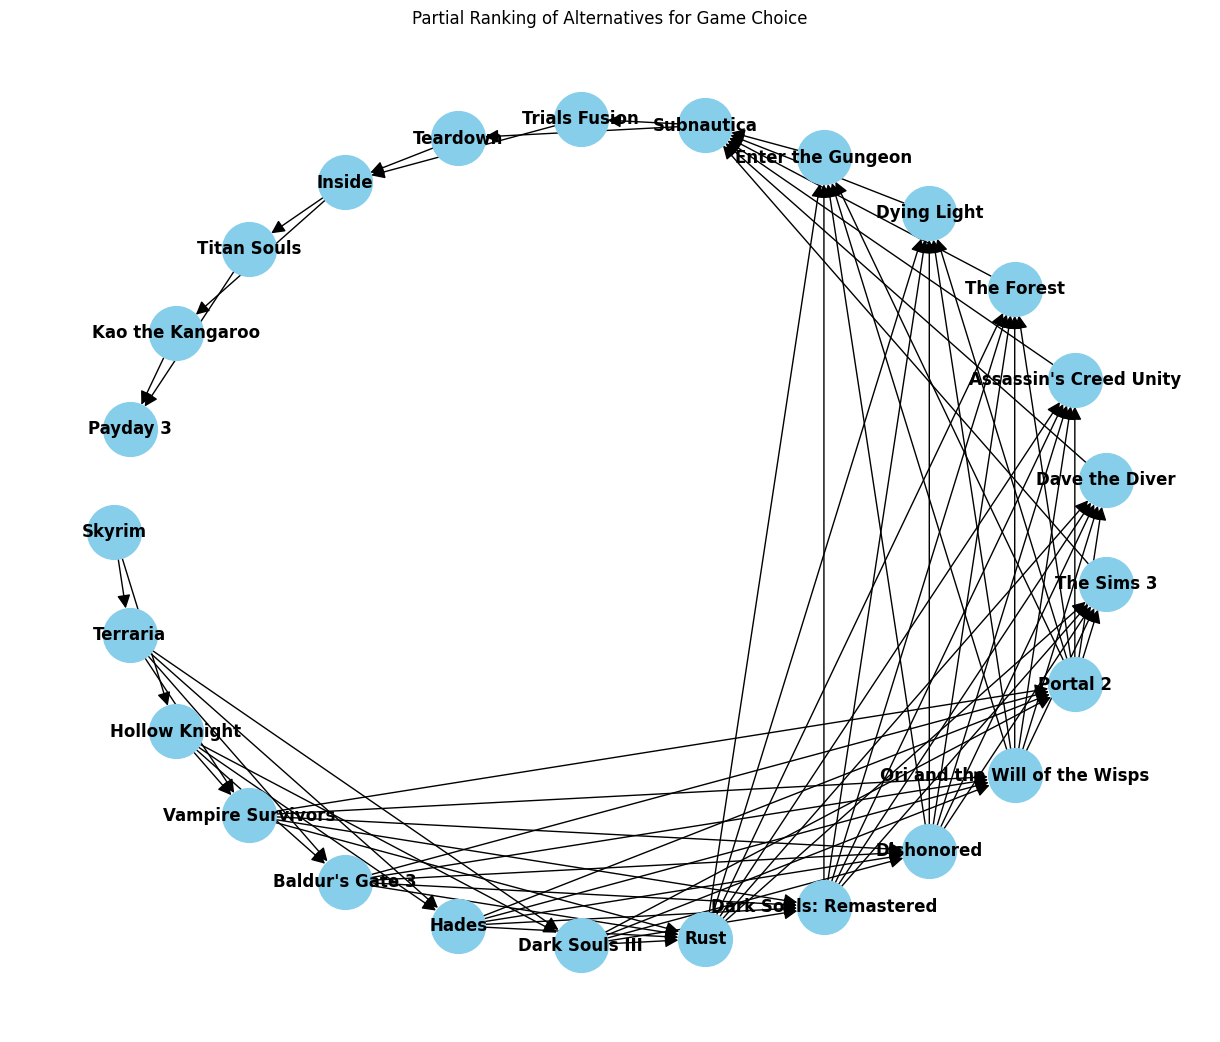

In [ ]:
plt.figure(figsize=(12, 10))
pos = nx.shell_layout(graph_I)
nx.draw(graph_I, pos, with_labels=True, node_size=1500, node_color='skyblue', font_size=12, font_weight='bold', arrowsize=20)
plt.title(f'Partial Ranking of Alternatives for {promete_I.name}')
plt.show()

The results for PROMETHEE I showcase Skyrim at the top of the ranking and Terraria, Hollow Knight admitting incomperability with respect to each other. Furthermore, many more alternatives admit incomperability in the lower ranks like Vampire Survivors, Baldur's Gate 3, Hades, Dark Souls III. These complex relationships as shown on the graph above may complicate the decision making process, cause the graph to look messy and confuse the decision maker (DM), as such, they highlight the need to use PROMETHEE II in the next section.

#### PROMETHEE II

In [ ]:
promete_II = PROMETHEE(name = "Game Choice", initialize_from_file=True, criteria = criteria, alternatives_path = "data.csv", version = 2)

In [ ]:
promete_II.display()

PROMETHEE Game Choice, version: 2
Criteria: num_of_achievements 
 type: gain 
 w: 0.047619047619047616 
 q: 8.0 
 p: 30.0
Criteria: length 
 type: gain 
 w: 0.07738095238095238 
 q: 5.0 
 p: 10.0
Criteria: price 
 type: cost 
 w: 0.16666666666666666 
 q: 10.0 
 p: 25.0
Criteria: critic_score 
 type: gain 
 w: 0.19642857142857142 
 q: 3.0 
 p: 6.0
Criteria: genres 
 type: gain 
 w: 0.2261904761904762 
 q: 1.5 
 p: 2.0
Criteria: user_score 
 type: gain 
 w: 0.2857142857142857 
 q: 2.0 
 p: 4.0
-----------------------Alternatives-----------------------



,name,price,critic_score,user_score,length,genres,num_of_achievements
0,Dark Souls: Remastered,150,84,83,44,11,41
1,Dark Souls III,200,89,90,49,11,43
2,Terraria,46,81,81,102,9,115
3,Baldur's Gate 3,250,96,89,107,8,54
4,Dave the Diver,92,90,83,32,7,43
5,Rust,153,69,65,37,10,92
6,Hollow Knight,68,90,91,42,10,63
7,Portal 2,46,95,89,14,7,51
8,Vampire Survivors,20,86,83,25,9,204
9,Hades,115,93,88,49,9,49


In [ ]:
result, graph_II = promete_II.solve()
result

[['Skyrim'],
 ['Terraria'],
 ['Hollow Knight'],
 ['Vampire Survivors'],
 ["Baldur's Gate 3"],
 ['Dark Souls III'],
 ['Hades'],
 ['Dishonored'],
 ['Rust'],
 ['Dark Souls: Remastered'],
 ['Ori and the Will of the Wisps'],
 ['Portal 2'],
 ['The Sims 3'],
 ['Dying Light'],
 ["Assassin's Creed Unity"],
 ['Enter the Gungeon'],
 ['Dave the Diver'],
 ['The Forest'],
 ['Subnautica'],
 ['Teardown'],
 ['Trials Fusion'],
 ['Inside'],
 ['Titan Souls'],
 ['Kao the Kangaroo'],
 ['Payday 3']]

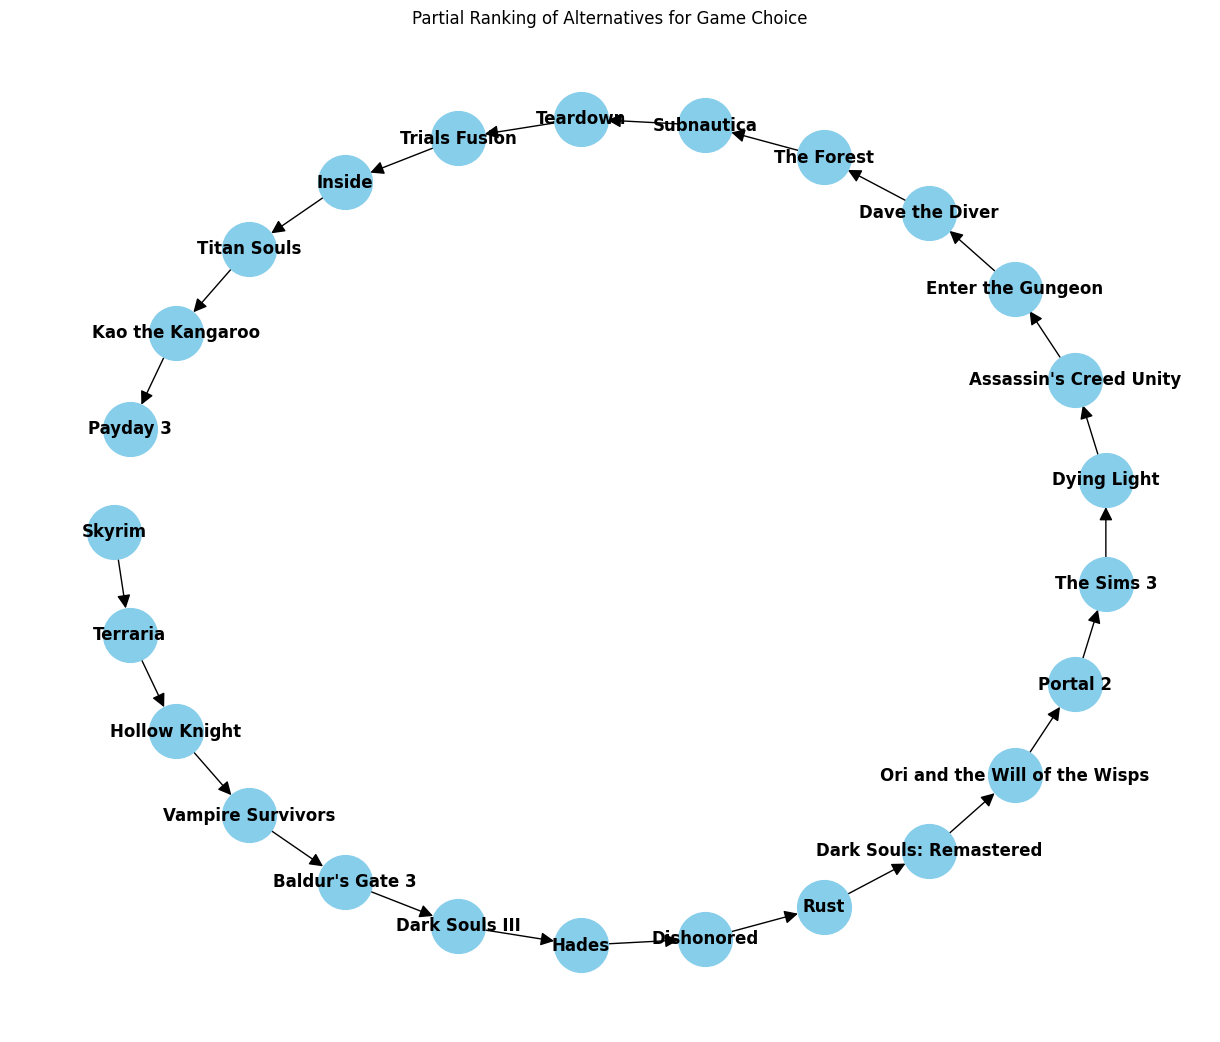

In [ ]:
plt.figure(figsize=(12, 10))
pos = nx.shell_layout(graph_II)
nx.draw(graph_II, pos, with_labels=True, node_size=1500, node_color='skyblue', font_size=12, font_weight='bold', arrowsize=20)
plt.title(f'Complete Ranking of Alternatives for {promete_II.name}')
plt.show()

As we can see, the top of our complete ranking is occupied by Skyrim, with Terraria, Hollow Knight, Vampire Survivors and Baldurs Gate 3 being next in the ranking. This ranking makes sense, since Skyrim had high values on Criteria of genres, length, critic_score and num_of_achievements while having a really low price. In comparison, a game like Baldurs Gate 3 has an even better value of critic_score but that success is temperd with much higher price and lower score on the genres criteria. As such, the position of the first few games in this ranking should be of no surprise, however, let's assume the results are not yet satisfying for us and we feel like we should adjust the indifference and preference thresholds to better reflect our tolerances for differences between criteria values.

### PROMETHEE - Iteration 2

#### Criteria Re-definition

In [ ]:
# Weights remain unchanged --> see the SRF section
weights

{'num_of_achievements': 0.047619047619047616,
 'length': 0.07738095238095238,
 'price': 0.16666666666666666,
 'critic_score': 0.19642857142857142,
 'genres': 0.2261904761904762,
 'user_score': 0.2857142857142857}

In [ ]:
q_vals = {'num_of_achievements': 4.0, 'length': 5.0, 'price': 10.0, 'critic_score': 5.0, 'genres': 2.0, 'user_score': 5.0}
p_vals = {'num_of_achievements': 12.0, 'length': 20.0, 'price': 20.0, 'critic_score': 8.0, 'genres': 3.0, 'user_score': 8.0}
criteria_types = {'num_of_achievements': "gain", 'length': "gain", 'price': "cost", 'critic_score': "gain", 'genres': "gain", 'user_score': "gain"}

In [ ]:
criteria = []
for key in weights.keys():
    criteria.append(Criteria(name = key, criteria_type = criteria_types[key], w = weights[key], q = q_vals[key], p = p_vals[key]))

#### PROMETHEE I

In [ ]:
promete_IB = PROMETHEE(name = "Game Choice Run 2", initialize_from_file=True, criteria = criteria, alternatives_path = "data.csv", version = 1)
promete_IB.display()

PROMETHEE Game Choice Run 2, version: 1
Criteria: num_of_achievements 
 type: gain 
 w: 0.047619047619047616 
 q: 4.0 
 p: 12.0
Criteria: length 
 type: gain 
 w: 0.07738095238095238 
 q: 5.0 
 p: 20.0
Criteria: price 
 type: cost 
 w: 0.16666666666666666 
 q: 10.0 
 p: 20.0
Criteria: critic_score 
 type: gain 
 w: 0.19642857142857142 
 q: 5.0 
 p: 8.0
Criteria: genres 
 type: gain 
 w: 0.2261904761904762 
 q: 2.0 
 p: 3.0
Criteria: user_score 
 type: gain 
 w: 0.2857142857142857 
 q: 5.0 
 p: 8.0
-----------------------Alternatives-----------------------



,name,price,critic_score,user_score,length,genres,num_of_achievements
0,Dark Souls: Remastered,150,84,83,44,11,41
1,Dark Souls III,200,89,90,49,11,43
2,Terraria,46,81,81,102,9,115
3,Baldur's Gate 3,250,96,89,107,8,54
4,Dave the Diver,92,90,83,32,7,43
5,Rust,153,69,65,37,10,92
6,Hollow Knight,68,90,91,42,10,63
7,Portal 2,46,95,89,14,7,51
8,Vampire Survivors,20,86,83,25,9,204
9,Hades,115,93,88,49,9,49


In [ ]:
result, graph_IB = promete_IB.solve()
result

[['Skyrim'],
 ['Terraria'],
 ['Hollow Knight', 'Vampire Survivors'],
 ["Baldur's Gate 3", 'Hades'],
 ['Dark Souls III', 'Dishonored'],
 ['The Sims 3',
  'Dark Souls: Remastered',
  'Portal 2',
  'Dave the Diver',
  'Rust',
  'Ori and the Will of the Wisps',
  'The Forest',
  'Dying Light'],
 ["Assassin's Creed Unity", 'Enter the Gungeon'],
 ['Subnautica'],
 ['Trials Fusion', 'Teardown', 'Inside'],
 ['Titan Souls', 'Kao the Kangaroo'],
 ['Payday 3']]

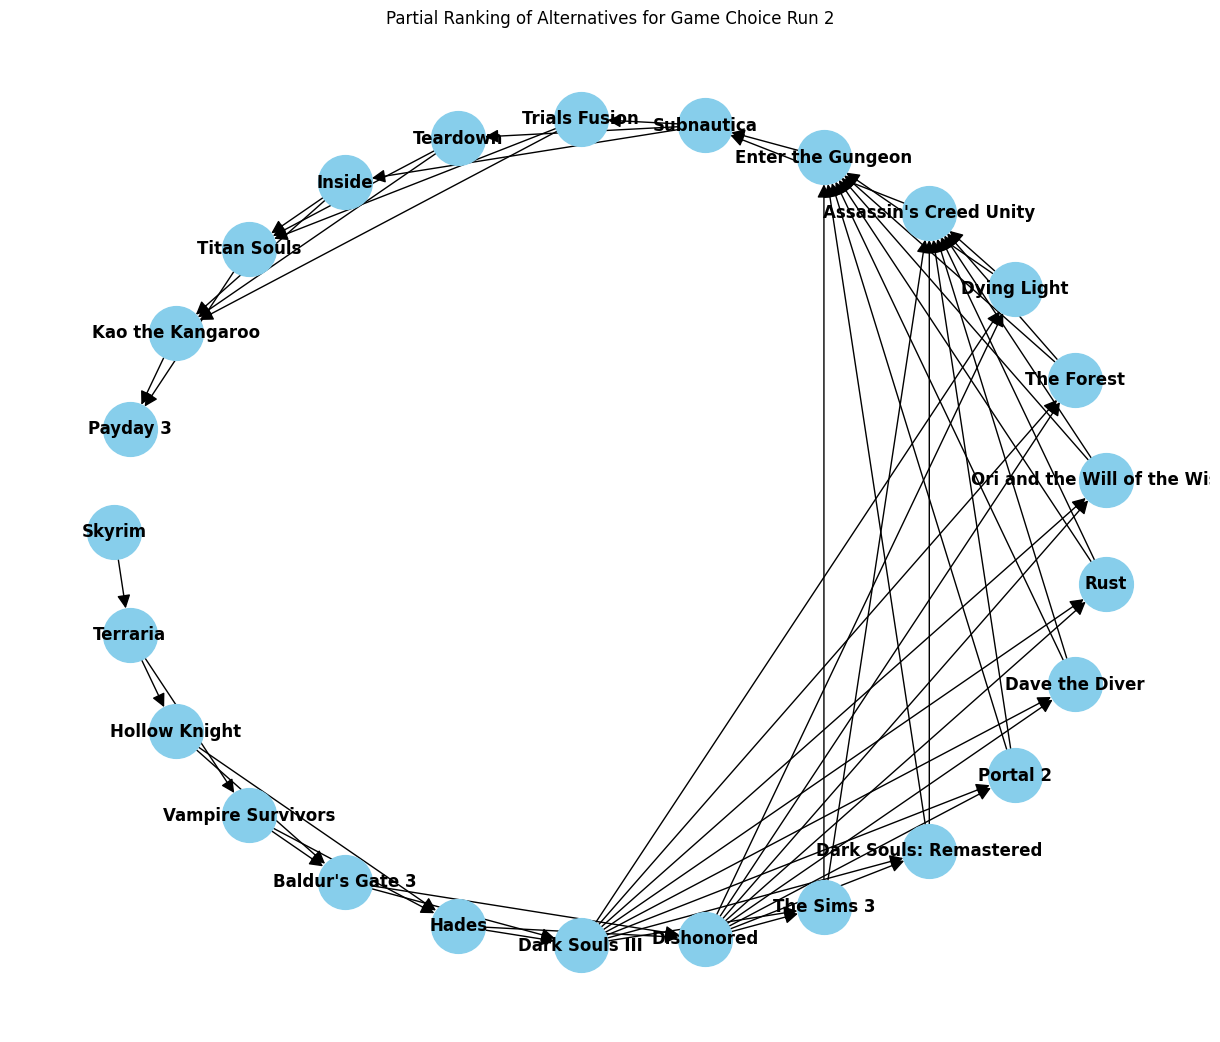

In [ ]:
plt.figure(figsize=(12, 10))
pos = nx.shell_layout(graph_IB)
nx.draw(graph_IB, pos, with_labels=True, node_size=1500, node_color='skyblue', font_size=12, font_weight='bold', arrowsize=20)
plt.title(f'Partial Ranking of Alternatives for {promete_IB.name}')
plt.show()

After the redefinition of indifference and preprefence thresholds we can see that fewer indifferences have been admitted for the first few positions in the ranking, furthermore the games like Skyrim, Terraria and Hollow Knight still stand at the top of the ranking.

#### PROMETHEE II

In [ ]:
promete_IIB = PROMETHEE(name = "Game Choice Run 2", initialize_from_file=True, criteria = criteria, alternatives_path = "data.csv", version = 2)
promete_IIB.display()

PROMETHEE Game Choice Run 2, version: 2
Criteria: num_of_achievements 
 type: gain 
 w: 0.047619047619047616 
 q: 4.0 
 p: 12.0
Criteria: length 
 type: gain 
 w: 0.07738095238095238 
 q: 5.0 
 p: 20.0
Criteria: price 
 type: cost 
 w: 0.16666666666666666 
 q: 10.0 
 p: 20.0
Criteria: critic_score 
 type: gain 
 w: 0.19642857142857142 
 q: 5.0 
 p: 8.0
Criteria: genres 
 type: gain 
 w: 0.2261904761904762 
 q: 2.0 
 p: 3.0
Criteria: user_score 
 type: gain 
 w: 0.2857142857142857 
 q: 5.0 
 p: 8.0
-----------------------Alternatives-----------------------



,name,price,critic_score,user_score,length,genres,num_of_achievements
0,Dark Souls: Remastered,150,84,83,44,11,41
1,Dark Souls III,200,89,90,49,11,43
2,Terraria,46,81,81,102,9,115
3,Baldur's Gate 3,250,96,89,107,8,54
4,Dave the Diver,92,90,83,32,7,43
5,Rust,153,69,65,37,10,92
6,Hollow Knight,68,90,91,42,10,63
7,Portal 2,46,95,89,14,7,51
8,Vampire Survivors,20,86,83,25,9,204
9,Hades,115,93,88,49,9,49


In [ ]:
result, graph_IIB = promete_IIB.solve()
result

[['Skyrim'],
 ['Terraria'],
 ['Hollow Knight'],
 ['Vampire Survivors'],
 ["Baldur's Gate 3"],
 ['Hades'],
 ['Dark Souls III'],
 ['Dishonored'],
 ['Rust'],
 ['The Sims 3'],
 ['Dark Souls: Remastered'],
 ['Portal 2'],
 ['Dying Light'],
 ['Enter the Gungeon'],
 ['Ori and the Will of the Wisps'],
 ["Assassin's Creed Unity"],
 ['Dave the Diver'],
 ['The Forest'],
 ['Subnautica'],
 ['Trials Fusion'],
 ['Teardown'],
 ['Inside'],
 ['Kao the Kangaroo'],
 ['Titan Souls'],
 ['Payday 3']]

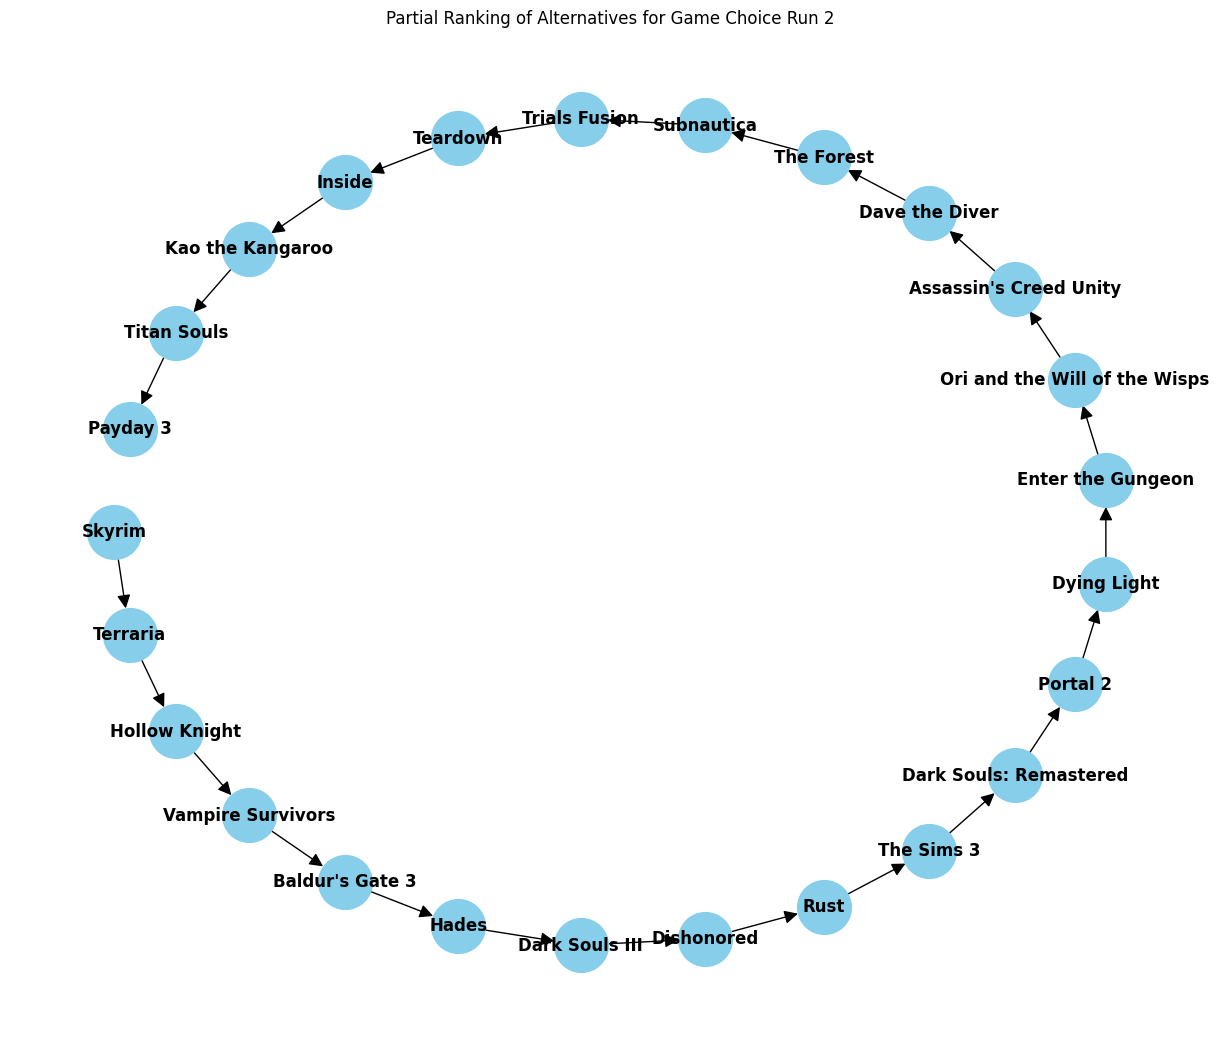

In [ ]:
plt.figure(figsize=(12, 10))
pos = nx.shell_layout(graph_IIB)
nx.draw(graph_IIB, pos, with_labels=True, node_size=1500, node_color='skyblue', font_size=12, font_weight='bold', arrowsize=20)
plt.title(f'Complete Ranking of Alternatives for {promete_IIB.name}')
plt.show()

Using the complete raking we can see that the first few positions in the ranking remained consistent with regards to redefiniton of the indifference and preference thresholds, for example the rank of Skyrim, Terraria, Hollow Knight, Vampire Survivors and Baldur's Gate 3 remained the same, however, this time Hades outranks Dark souls III - it was the other way around with the earlier thresholds. We can also see difference in ranking between Dark Souls: Remastered and The Sims 3. However, the fact that the top games didn't change their rank implies that perhaps one of them is the correct choice for someone looking for a good game on a budget with lots of time to spare.

### 3.2. Problem analysis with the use of PROMETHEE I and II

1. Write the preferential information you provided at the input of the method.

A: In both cases weights were computed using SRF procedure using the following list:

['num_of_achievements', 'length', 'w', 'w', 'price', 'critic_score', 'genres', 'w', 'user_score']

Iteration 1:

| Criteria            | Type  | Weight  | q_value | p_value |
|---------------------|-------|---------|---------|---------|
| num_of_achievements | Gain  | 0.0476  | 8.0     | 30.0    |
| length              | Gain  | 0.0774  | 5.0     | 10.0    |
| price               | Cost  | 0.1667  | 10.0    | 25.0    |
| critic_score        | Gain  | 0.1964  | 3.0     | 6.0     |
| genres              | Gain  | 0.2262  | 1.5     | 2.0     |
| user_score          | Gain  | 0.2857  | 2.0     | 4.0     |


Iteration 2:

| Criteria            | Type  | Weight  | q_value | p_value |
|---------------------|-------|---------|---------|---------|
| num_of_achievements | Gain  | 0.0476  | 4.0     | 12.0    |
| length              | Gain  | 0.0774  | 5.0     | 20.0    |
| price               | Cost  | 0.1667  | 10.0    | 20.0    |
| critic_score        | Gain  | 0.1964  | 5.0     | 8.0     |
| genres              | Gain  | 0.2262  | 2.0     | 3.0     |
| user_score          | Gain  | 0.2857  | 5.0     | 8.0     |


2. Enter the final result obtained with the method. Usually, the first result is not the final one, you can slightly adjust the parameter values to your preferences.

A: Final results for both partial and complete ranking shown below, as we can see games like Skyrim, Terraria and Hollow Knight achieve very high ranks in both cases.

Partial Ranking:

Skyrim, Terraria, [Hollow Knight, Vampire Survivors], [Baldur's Gate 3, Hades], [Dark Souls III, Dishonored], [The Sims 3, Dark Souls: Remastered, Portal 2, Dave the Diver, Rust, Ori and the Will of the Wisps, The Forest, Dying Light], [Assassin's Creed Unity, Enter the Gungeon], Subnautica, [Trials Fusion, Teardown, Inside], [Titan Souls, Kao the Kangaroo], Payday 3

Complete Ranking:

Skyrim, Terraria, Hollow Knight, Vampire Survivors, Baldur's Gate 3, Hades, Dark Souls III, Dishonored, Rust, The Sims 3, Dark Souls: Remastered, Portal 2, Dying Light, Enter the Gungeon, Ori and the Will of the Wisps, Assassin's Creed Unity, Dave the Diver, The Forest, Subnautica, Trials Fusion, Teardown, Inside, Kao the Kangaroo, Titan Souls, Payday 3

3. Compare the complete and partial ranking.

A: In both complete and partial ranking the top rank is occupied by Skyrim with Terraria second and Hollow Knight and Vampire Survivors admitting incomperability as opposed to the complete ranking where Hollow Knight ranks higher. The comparison becomes more difficult for lower rankings with multiple incomperabilities, however general trends like Dark Souls: Remastered sitting somehwere in the middle of the rankings and Payday 3 being at the bottom are consistent across both partial and complete ranking.

4. Comment on the compliance of the results with your expectations and preferences. Refer, among others, to to the results for the alternatives that you indicated as the best and worst during the data
analysis. What operations were required to obtain the final result (e.g. changing the ranking of criteria, adding blank cards, changing the value of threshold)?

A: The results, especially for the top ranks are in-line with the expectations written in the beggining section. Skyrim and Hollow Knight were both indicated as strongly preferable to other alternatives and Padyday 3 as well as Assassin's Creed Unity were both expected to be towards the bottoms of the rankings, all the aforemetnioned predictions came true in the PROMETHEE method. Lastly, all the pairwise comparisons written in the data section came true, lending credence to the correct output of the PROMETHEE method and correct choice of weights and thresholds.

## ELECTRE

#### Classes:
- Very promising
- Worth considering
- Not preferrable
- Unacceptable

#### Boundary profiles:

| name    | price | critic_score | user_score | length | genres   | num_of_achievements |
|---------|-------|--------------|------------|--------|----------|---------------------|
| b_0     | 250   | 50           | 31         | 20     | 0        | 5                   |
| b_1     | 200   | 67           | 50         | 50     | 3        | 20                  |
| b_2     | 140   | 75           | 73         | 70     | 5        | 50                  |
| b_3     | 90    | 88           | 83         | 85     | 7        | 100                 |
| b_4     | 20    | 96           | 91         | 114    | 11       | 204                 |

In [ ]:
class ELECTRE_TRI_B():
    '''
    Class implementing ELECTRE TRI-B algortihm for sorting.
    '''
    def __init__(self, name: str = "MCDA Problem", criteria: list = [], alternatives = None, credibility_threshold = 0.6, assignment = "optimistic"):
        '''
        Initialize instance of ELECTRE
        Parameters:
            - name (str, optional): Name of the problem to be solved, default - MCDA Problem
            - criteria (list): list of criteria, each criteria instance of Criteria_ELECTRE object, default []
            - alternatives (datframe): dataframe of alternatives, columns should be consistent with the previously defined Criteria and one more column "name" should be present, default -> None
            - credibility_threshold (float): credibility_threshold
        '''
        self.name = name
        self.credibility_threshold = credibility_threshold

        assert assignment == "optimistic" or assignment == "pessimistic", "Wrong assignment type provided"
        self.assignment = assignment

        if alternatives is not None and not isinstance(alternatives, pd.DataFrame):
            raise TypeError("Alternatives must be a pandas DataFrame.")

        self.criteria = criteria
        self.alternatives = alternatives

        self.preference_structure = None
        self.class_assignments = None

    def __str__(self):
        '''
        Used for printing - print()
        '''
        electre_text = f"ELECTRE TRI-B {self.name}"
        for criterion in self.criteria:
            cr_printed = criterion.__str__()
            electre_text += cr_printed
        electre_text += "\n-----------------------Alternatives-----------------------\n"
        electre_text += self.alternatives.__str__()
        return electre_text

    def display(self):
        '''
        More complex version of printing, provides better datframe visualization, but does not support use through print().
        '''
        electre_text = f"ELECTRE TRI-B {self.name}"
        for criterion in self.criteria:
            cr_printed = criterion.__str__()
            electre_text += cr_printed
        electre_text += "\n-----------------------Alternatives-----------------------\n"
        print(electre_text)
        return self.alternatives.head(len(self.alternatives))

    def get_marginal_concordance(self):
        '''
        Calculates marginal concordance, used in solve() method.
        '''
        marginal_concordance = {crt.name: None for crt in self.criteria}
        copied_alts = self.alternatives.copy()
        for crt in self.criteria:
            crt_concordance_pair_results = []

            for _, alt in copied_alts.iterrows():
                # Value of g-th criteria
                alt_val = alt[crt.name]

                for b_i, b_val in enumerate(crt.boundary_profiles):
                    pair = [alt["name"], f"b_{b_i}"]
                    rev_pair = [f"b_{b_i}", alt["name"]]

                    res = calculate_concordance_index(alt_val, b_val, crt.q[b_i], crt.p[b_i], crt.criteria_type)
                    rev_res = calculate_concordance_index(b_val, alt_val, crt.q[b_i], crt.p[b_i], crt.criteria_type)

                    # if pair[0] == "a_1" and pair[1] == "b_1" and crt.name == "g2":
                    #     print(res, pair, b_i, b_val, alt_val, crt.q[b_i], crt.p[b_i], crt.criteria_type)

                    crt_concordance_pair_results.append([pair, res])
                    crt_concordance_pair_results.append([rev_pair, rev_res])

            marginal_concordance[crt.name] = crt_concordance_pair_results

        return marginal_concordance

    def get_marginal_discordance(self):
        '''
        Calculates marginal discordance, used in solve() method.
        '''
        marginal_discordance = {crt.name: None for crt in self.criteria}
        copied_alts = self.alternatives.copy()
        for crt in self.criteria:
            crt_discordance_pair_results = []

            for _, alt in copied_alts.iterrows():
                # Value of g-th criteria
                alt_val = alt[crt.name]

                for b_i, b_val in enumerate(crt.boundary_profiles):
                    pair = [alt["name"], f"b_{b_i}"]
                    rev_pair = [f"b_{b_i}", alt["name"]]

                    res = calculate_discordance_index(alt_val, b_val, crt.v[b_i], crt.p[b_i], crt.criteria_type)
                    rev_res = calculate_discordance_index(b_val, alt_val, crt.v[b_i], crt.p[b_i], crt.criteria_type)

                    crt_discordance_pair_results.append([pair, res])
                    crt_discordance_pair_results.append([rev_pair, rev_res])

            marginal_discordance[crt.name] = crt_discordance_pair_results

        return marginal_discordance

    def get_comprehensive_concordance(self, marginal_concordance):
        comprehensive_concordances = []

        criteria_weights = [[crt.name, crt.w] for crt in self.criteria]
        weight_total = sum([x[1] for x in criteria_weights])
        criteria_weights = dict(criteria_weights)

        copied_alts = self.alternatives.copy()
        for _, alt in copied_alts.iterrows():
            alt_name = alt["name"]

            for b_id in range(len(self.criteria[0].boundary_profiles)):
                b_name = f"b_{b_id}"

                eq = 0
                rev_eq = 0
                for g_name, concordanes in marginal_concordance.items():
                    for conc in concordanes:
                        if conc[0][0] == alt_name and conc[0][1] == b_name:
                            eq += criteria_weights[g_name] * conc[1]

                        if conc[0][0] == b_name and conc[0][1] == alt_name:
                            rev_eq += criteria_weights[g_name] * conc[1]

                res = eq/weight_total
                rev_res = rev_eq/weight_total
                comprehensive_concordances.append([[alt_name, b_name], res])
                comprehensive_concordances.append([[b_name, alt_name], rev_res])

        return comprehensive_concordances

    def get_outranking_credibility(self, comprehensive_concordance, marginal_discordance):
        outrankings = []
        for concordance in comprehensive_concordance:
            a_name, b_name = concordance[0]
            C = concordance[1]
            if C == 0.0:
                outrankings.append([concordance[0], 0])
                continue

            eq = C
            for _, discordances in marginal_discordance.items():
                for discordance in discordances:
                    if discordance[0][0] == a_name and discordance[0][1] == b_name:
                        if discordance[1] > C:
                            eq *= (1-discordance[1])/(1-C)

            outrankings.append([concordance[0], eq])

        return outrankings

    def get_preference_structure(self, outranking_credibility):
        i = 0
        preference_structure = []
        for ab, ba in zip(outranking_credibility[:-1], outranking_credibility[1:]):
            if i%2 != 0:
                i += 1
                continue

            res = None
            if ab[1] >= self.credibility_threshold and ba[1] < self.credibility_threshold:
                res = ">"

            elif ab[1] < self.credibility_threshold and ba[1] >= self.credibility_threshold:
                res = "<"

            elif ab[1] >= self.credibility_threshold and ba[1] >= self.credibility_threshold:
                res = "|"

            elif ab[1] < self.credibility_threshold and ba[1] < self.credibility_threshold:
                res = "?"

            assert res is not None, "Result cannot be ambiguous"

            preference_structure.append([ab[0], res])
            i += 1

        used_alts = set([])
        alt_preference_strings = []
        i = -1
        for p, res in preference_structure:
            alt = p[0]

            if alt not in used_alts:
                alt_preference_strings.append([alt, ""])
                used_alts.add(alt)
                i += 1

            alt_preference_strings[i][1] += res

        return alt_preference_strings

    def get_pessimistic_assignment(self, preference_structure):
        assignment = {}

        for alt_name, pref_string in preference_structure:
            opt_class = len(pref_string)
            for c in pref_string[::-1]:
                if c == ">" or c =="|":
                    break
                opt_class -= 1

            assignment[alt_name] = opt_class

        return assignment

    def get_optimistic_assignment(self, preference_structure):
        assignment = {}

        for alt_name, pref_string in preference_structure:
            for opt_class, c in enumerate(pref_string):
                if c == "<":
                    break

            assignment[alt_name] = opt_class

        return assignment

    def solve(self):
        marginal_concordance = self.get_marginal_concordance()
        marginal_discordance = self.get_marginal_discordance()

        comprehensive_concordance = self.get_comprehensive_concordance(marginal_concordance)
        outranking_credibility = self.get_outranking_credibility(comprehensive_concordance, marginal_discordance)
        preference_structure = self.get_preference_structure(outranking_credibility)
        self.preference_structure = dict(preference_structure)

        if self.assignment == "pessimistic":
            assignment = self.get_pessimistic_assignment(preference_structure)
        elif self.assignment == "optimistic":
            assignment = self.get_optimistic_assignment(preference_structure)
        else:
            raise Exception("Wrong assignemnt type provided")

        self.class_assignments = assignment
        return assignment

    def get_preference_results(self):
        if self.preference_structure is None:
            print("Preference structure not created, run solve() first")
            return None

        return self.preference_structure

    def _debug_solve(self):
        marginal_concordance = self.get_marginal_concordance()
        marginal_discordance = self.get_marginal_discordance()

        for k, i in marginal_concordance.items():
            print(k)
            for ist in i:
                if ist[0][1].startswith("a_1") or ist[0][0].startswith("a_1"):
                    print(ist)
        print()

        for k, i in marginal_discordance.items():
            print(k)
            for ist in i:
                if ist[0][1].startswith("a_1") or ist[0][0].startswith("a_1"):
                    print(ist)
        print()

        comprehensive_concordance = self.get_comprehensive_concordance(marginal_concordance)
        for c in comprehensive_concordance:
            if c[0][1].startswith("a_1") or c[0][0].startswith("a_1"):
                print(c)
        print()

        outranking_credibility = self.get_outranking_credibility(comprehensive_concordance, marginal_discordance)
        for c in outranking_credibility:
            if c[0][1].startswith("a_1") or c[0][0].startswith("a_1"):
                print(c)
        print()

        preference_structure = self.get_preference_structure(outranking_credibility)
        print(preference_structure)
        print()

        if self.assignment == "pessimistic":
            assignment = self.get_pessimistic_assignment(preference_structure)
        elif self.assignment == "optimistic":
            assignment = self.get_optimistic_assignment(preference_structure)
        else:
            raise Exception("Wrong assignemnt type provided")

        self.class_assignments = assignment
        return assignment

    def show_class_assignments(self):
        if self.class_assignments is None:
            print("Class assingments not created, run solve() first")
            return None

        class_groups = {}
        for alternative, class_num in self.class_assignments.items():
            if class_num not in class_groups:
                class_groups[class_num] = []
            class_groups[class_num].append(alternative)

        class_groups = sorted(class_groups.items(), key=lambda x: x[0], reverse=True)
        print("============================================")
        print(f"{self.assignment[0].upper() + self.assignment[1:]} Alternative Classification:")
        print("============================================")
        for class_num, alts in class_groups:
            print(f"Class {class_num}:")
            for alt in alts:
                print(f"  - {alt}")


In [ ]:
criteria_names = ['num_of_achievements', 'length', 'price', 'critic_score', 'genres', 'user_score']
criteria_types = ["gain", "gain", "cost", "gain", "gain", "gain"]
criteria_q = [[3.3]*6, [5.0]*6, [3.0]*6, [0.0]*6, [9.0]*6, [1.0]*6]
criteria_p = [[92.0]*6, [20.0]*6, [9.0]*6, [1.0]*6, [15.0]*6, [2.0]*6]
criteria_v = [[150.0]*6, [50.0]*6, [25.0]*6, [10.0]*6, [30.0]*6, [10.0]*6]
criteria_boundaries = [
    [  5,  20,  50, 100, 204],
    [ 20,  50,  70,  85, 114],
    [250, 200, 140,  90,  20],
    [ 50,  67,  75,  88,  96],
    [  0,   3,   5,   7,  11],
    [ 31,  50,  73,  83,  91]
]

In [ ]:
criteria_importance = ['num_of_achievements', 'length', 'w', 'w', 'price', 'critic_score', 'genres', 'w', 'user_score']
weights = srf_procedure(criteria_importance, 6)
weights

{'num_of_achievements': 0.047619047619047616,
 'length': 0.07738095238095238,
 'price': 0.16666666666666666,
 'critic_score': 0.19642857142857142,
 'genres': 0.2261904761904762,
 'user_score': 0.2857142857142857}

In [ ]:
criteria_electre = [Criteria_ELECTRE(name, t, weights[name], q, p, v, b) for name, t, q, p, v, b in zip(criteria_names, criteria_types, criteria_q, criteria_p, criteria_v, criteria_boundaries)]
# for c in criteria_electre:
#     print(c)

In [ ]:
data = pd.read_csv("data.csv")
data

,name,price,critic_score,user_score,length,genres,num_of_achievements
0,Dark Souls: Remastered,150,84,83,44,11,41
1,Dark Souls III,200,89,90,49,11,43
2,Terraria,46,81,81,102,9,115
3,Baldur's Gate 3,250,96,89,107,8,54
4,Dave the Diver,92,90,83,32,7,43
5,Rust,153,69,65,37,10,92
6,Hollow Knight,68,90,91,42,10,63
7,Portal 2,46,95,89,14,7,51
8,Vampire Survivors,20,86,83,25,9,204
9,Hades,115,93,88,49,9,49


### 3.3. Problem analysis with the use of ELECTRE TRI-B

1. Write the preferential information you provided at the input of the method.

A:
#### Classes:
- Very promising
- Worth considering
- Not preferrable
- Unacceptable

#### Boundary profiles:

| name    | price | critic_score | user_score | length | genres   | num_of_achievements |
|---------|-------|--------------|------------|--------|----------|---------------------|
| b_0     | 250   | 50           | 31         | 20     | 0        | 5                   |
| b_1     | 200   | 67           | 50         | 50     | 3        | 20                  |
| b_2     | 140   | 75           | 73         | 70     | 5        | 50                  |
| b_3     | 90    | 88           | 83         | 85     | 7        | 100                 |
| b_4     | 20    | 96           | 91         | 114    | 11       | 204                 |

2. Enter the final result obtained with the method. Usually, the first result is not the final one, you can slightly adjust the parameter values to your preferences.

A:

3. Comment on the compliance of the results with your expectations and preferences. Refer, among
others, to to the results for the alternatives that you indicated as the best and worst during the data
analysis. What operations were required to obtain the final result (e.g. changing the ranking of criteria, adding blank cards, changing the value of threshold)?

A:

4. Compare the optimistic and pessimistic class assignments.

A:

5. Comment on the compliance of the results with your expectations and preferences. Refer, among
others, to to the results for the alternatives that you indicated as the best and worst during the data
analysis. What operations were required to obtain the final result (e.g. changing the ranking of criteria, adding blank cards, changing the value of threshold, boundaries or the λ parameter)?

A:

## Use

### ELECTRE

In [ ]:
electre = ELECTRE_TRI_B(criteria = criteria_electre, alternatives = data, credibility_threshold = 0.65, assignment="pessimistic")
electre.solve()

{'Dark Souls: Remastered': 3,
 'Dark Souls III': 2,
 'Terraria': 3,
 "Baldur's Gate 3": 1,
 'Dave the Diver': 3,
 'Rust': 2,
 'Hollow Knight': 4,
 'Portal 2': 2,
 'Vampire Survivors': 3,
 'Hades': 3,
 'Subnautica': 3,
 'Dishonored': 2,
 'Ori and the Will of the Wisps': 2,
 'Inside': 2,
 'The Forest': 3,
 'Skyrim': 4,
 'Teardown': 3,
 'Dying Light': 3,
 'Enter the Gungeon': 3,
 'Payday 3': 1,
 'Kao the Kangaroo': 2,
 "Assassin's Creed Unity": 2,
 'Trials Fusion': 2,
 'The Sims 3': 3,
 'Titan Souls': 2}

In [ ]:
electre.get_preference_results()

{'Dark Souls: Remastered': '>>><<',
 'Dark Souls III': '>>??<',
 'Terraria': '>>>?<',
 "Baldur's Gate 3": '>???<',
 'Dave the Diver': '>>><<',
 'Rust': '>><<<',
 'Hollow Knight': '>>>><',
 'Portal 2': '>>??<',
 'Vampire Survivors': '>>>?<',
 'Hades': '>>>?<',
 'Subnautica': '>>><<',
 'Dishonored': '>>??<',
 'Ori and the Will of the Wisps': '>>??<',
 'Inside': '>>??<',
 'The Forest': '>>><<',
 'Skyrim': '>>>><',
 'Teardown': '>>><<',
 'Dying Light': '>>><<',
 'Enter the Gungeon': '>>><<',
 'Payday 3': '>?<<<',
 'Kao the Kangaroo': '>>?<<',
 "Assassin's Creed Unity": '>><<<',
 'Trials Fusion': '>>?<<',
 'The Sims 3': '>>>?<',
 'Titan Souls': '>>?<<'}

In [ ]:
electre.show_class_assignments()

Pessimistic Alternative Classification:
Class 4:
  - Hollow Knight
  - Skyrim
Class 3:
  - Dark Souls: Remastered
  - Terraria
  - Dave the Diver
  - Vampire Survivors
  - Hades
  - Subnautica
  - The Forest
  - Teardown
  - Dying Light
  - Enter the Gungeon
  - The Sims 3
Class 2:
  - Dark Souls III
  - Rust
  - Portal 2
  - Dishonored
  - Ori and the Will of the Wisps
  - Inside
  - Kao the Kangaroo
  - Assassin's Creed Unity
  - Trials Fusion
  - Titan Souls
Class 1:
  - Baldur's Gate 3
  - Payday 3


### PROMETHEE

In [ ]:
weights

{'num_of_achievements': 0.047619047619047616,
 'length': 0.07738095238095238,
 'price': 0.16666666666666666,
 'critic_score': 0.19642857142857142,
 'genres': 0.2261904761904762,
 'user_score': 0.2857142857142857}

In [ ]:
criteria = [
    Criteria(name = "price", criteria_type = "cost", w = weights["price"], q = 3.0, p=9.0),
    Criteria(name = "critic_score", criteria_type = "gain", w = weights["critic_score"], q = 0.0, p=1.0),
    Criteria(name = "user_score", criteria_type = "gain", w = weights["user_score"], q = 1.0, p=2.0),
    Criteria(name = "length", criteria_type = "gain", w = weights["length"], q = 5.0, p=20.0),
    Criteria(name = "genres", criteria_type = "gain", w = weights["genres"], q = 9.0, p=15.0),
    Criteria(name = "num_of_achievements", criteria_type = "gain", w = weights["num_of_achievements"], q = 3.3, p=92.0),
]

In [ ]:
promete = PROMETHEE(criteria = criteria, alternatives = data, version=2)
result, graph = promete.solve()

In [ ]:
result

[['Hollow Knight'],
 ['Portal 2'],
 ['Skyrim'],
 ['Hades'],
 ["Baldur's Gate 3"],
 ['Vampire Survivors'],
 ['Ori and the Will of the Wisps'],
 ['Dishonored'],
 ['Dark Souls III'],
 ['Inside'],
 ['Dave the Diver'],
 ['Terraria'],
 ['The Sims 3'],
 ['Subnautica'],
 ['Enter the Gungeon'],
 ['Dark Souls: Remastered'],
 ['The Forest'],
 ['Dying Light'],
 ['Teardown'],
 ['Trials Fusion'],
 ['Titan Souls'],
 ["Assassin's Creed Unity"],
 ['Rust'],
 ['Kao the Kangaroo'],
 ['Payday 3']]

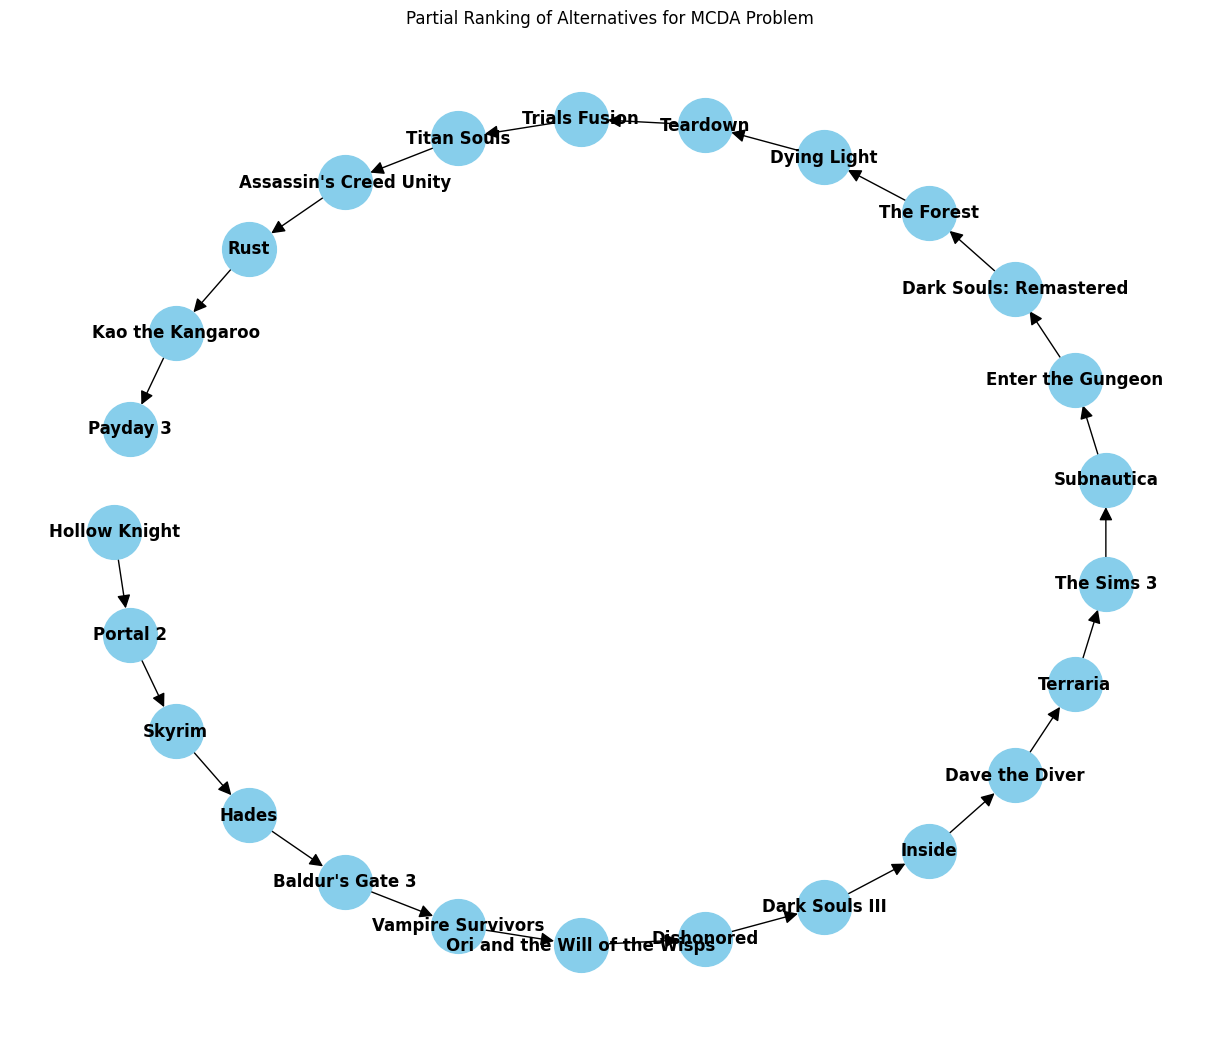

In [ ]:
plt.figure(figsize=(12, 10))
pos = nx.shell_layout(graph)
nx.draw(graph, pos, with_labels=True, node_size=1500, node_color='skyblue', font_size=12, font_weight='bold', arrowsize=20)
plt.title(f'Partial Ranking of Alternatives for {promete.name}')
plt.show()

## Tests

### ELECTRE

In [ ]:
criteria = [
    Criteria_ELECTRE(name = "g1", criteria_type = "gain", w = 0.4, q = [2.0, 3.0], p=[6.0, 7.0], v=[20.0, 20.0], boundary_profiles=[64, 86]),
    Criteria_ELECTRE(name = "g2", criteria_type = "gain", w = 0.3, q = [2.0, 3.0], p=[5.0, 8.0], v=[24.0, 25.0], boundary_profiles=[61, 84]),
    Criteria_ELECTRE(name = "g3", criteria_type = "gain", w = 0.25, q = [0.0, 0.0], p=[2.0, 2.0], v=[float("inf"), float("inf")], boundary_profiles=[32, 43]),
    Criteria_ELECTRE(name = "g4", criteria_type = "gain", w = 0.05, q = [0.0, 0.0], p=[2.0, 2.0], v=[float("inf"), float("inf")], boundary_profiles=[32, 43])
]

data = {
    'name': [f"a_{i}" for i in range(1, 9)],
    "g1": [90, 40, 94, 78, 60, 64, 62, 70],
    "g2": [86, 90, 100, 76, 60, 72, 88, 30],
    "g3": [46, 14, 40, 30, 30, 12, 22, 12],
    "g4": [30, 48, 36, 50, 30, 46, 48, 12]
}

alternatives = pd.DataFrame(data)

In [ ]:
electre = ELECTRE_TRI_B(criteria = criteria, alternatives = alternatives, credibility_threshold = 0.65, assignment="pessimistic")
electre.solve()

{'a_1': 2,
 'a_2': 0,
 'a_3': 2,
 'a_4': 1,
 'a_5': 0,
 'a_6': 1,
 'a_7': 1,
 'a_8': 0}

In [ ]:
criteria = [
    Criteria_ELECTRE(name = "g1", criteria_type = "cost", w = 0.21, q = [400.0,400.0,400.0,400.0], p=[500.0,500.0,500.0,500.0], v=[1500.0,1500.0,1500.0,1500.0], boundary_profiles=[2000, 1000, 500, 110]),
    Criteria_ELECTRE(name = "g2", criteria_type = "cost", w = 0.15, q = [150.0,150.0,150.0,150.0], p=[300.0,300.0,300.0,300.0], v=[1000.0,1000.0,1000.0,1000.0], boundary_profiles=[1300, 800, 300, 110]),
    Criteria_ELECTRE(name = "g3", criteria_type = "gain", w = 0.23, q = [0.0,0.0,0.0,0.0], p=[1.0,1.0,1.0,1.0], v=[3.0,3.0,3.0,3.0], boundary_profiles=[0, 1, 2, 4]),
    Criteria_ELECTRE(name = "g4", criteria_type = "gain", w = 0.21, q = [1.0,1.0,1.0,1.0], p=[1.0,1.0,1.0,1.0], v=[2.0,2.0,2.0,2.0], boundary_profiles=[0, 1, 2, 4]),
    Criteria_ELECTRE(name = "g5", criteria_type = "gain", w = 0.12, q = [1.0,1.0,1.0,1.0], p=[2.0,2.0,2.0,2.0], v=[3.0,3.0,3.0,3.0], boundary_profiles=[1, 2, 3, 4]),
    Criteria_ELECTRE(name = "g6", criteria_type = "gain", w = 0.08, q = [1.0,1.0,1.0,1.0], p=[3.0,3.0,3.0,3.0], v=[4.0,4.0,4.0,4.0], boundary_profiles=[0, 1, 2, 5])
]

data = {
    'name': [f"a_{i}" for i in range(1, 7)],
    "g1": [1600, 1700, 1700, 2000, 1200, 110],
    "g2": [300, 400, 550, 350, 110, 1300],
    "g3": [2, 2, 4, 3, 1, 1],
    "g4": [3, 2, 0, 2, 0, 1],
    "g5": [4, 4, 3, 4, 1, 3],
    "g6": [5, 5, 3, 2, 1, 4]
}

alternatives = pd.DataFrame(data)
alternatives

,name,g1,g2,g3,g4,g5,g6
0,a_1,1600,300,2,3,4,5
1,a_2,1700,400,2,2,4,5
2,a_3,1700,550,4,0,3,3
3,a_4,2000,350,3,2,4,2
4,a_5,1200,110,1,0,1,1
5,a_6,110,1300,1,1,3,4


In [ ]:
electre = ELECTRE_TRI_B(criteria = criteria, alternatives = alternatives, credibility_threshold = 0.65, assignment="pessimistic")
electre.solve()

{'a_1': 3, 'a_2': 3, 'a_3': 2, 'a_4': 2, 'a_5': 2, 'a_6': 2}

### SRF

In [ ]:
# criteria_importance = ['num_of_achievements', 'length', 'w', 'w', 'price', 'critic_score', 'genres', 'w', 'user_score']
# criteria_importance = ['services', 'stars', 'w', 'dist_downtown', 'w', 'w', ['dist_cong', 'restaurants'], 'sports_eq']
criteria_importance = ['g4', 'w', 'w', 'w', 'g3', 'g2', 'w', 'g1']

srf_procedure(criteria_importance, 3)

{'g4': 0.11666666666666667,
 'g3': 0.25,
 'g2': 0.2833333333333334,
 'g1': 0.35000000000000003}

## Conclusions and Comparison of Methods' Results